# Pairwise Sequence Alignment with BAT_LIKE_SARS and NOVEL_COVID_19 Genomes

### Aligning line by line

In [484]:
#!/usr/bin/env python

from __future__ import print_function, division

from operator import itemgetter
import os
import sys
import tempfile
import warnings

try:
    from Bio import pairwise2
    from Bio.SubsMat import MatrixInfo as matlist
except ImportError as exception:
    print("[!] Could not import Biopython modules", file=sys.stderr)
    raise exception

#
def align_sequences(sequence_A, sequence_B, **kwargs):
    """
    Performs a global pairwise alignment between two sequences
    using the BLOSUM62 matrix and the Needleman-Wunsch algorithm
    as implemented in Biopython. Returns the alignment, the sequence
    identity and the residue mapping between both original sequences.
    """

    def _calculate_identity(sequenceA, sequenceB):
        """
        Returns the percentage of identical characters between two sequences.
        Assumes the sequences are aligned.
        """

        sa, sb, sl = sequenceA, sequenceB, len(sequenceA)
        matches = [sa[i] == sb[i] for i in range(sl)]
        seq_id = (100 * sum(matches)) / sl

        gapless_sl = sum([1 for i in range(sl) if (sa[i] != '-' and sb[i] != '-')])
        gap_id = (100 * sum(matches)) / gapless_sl
        return (seq_id, gap_id)

    #
    matrix = kwargs.get('matrix', matlist.blosum62)
    gap_open = kwargs.get('gap_open', -10.0)
    gap_extend = kwargs.get('gap_extend', -0.5)

    # Needleman-Wunsch algorithm
    alns = pairwise2.align.globalds(sequence_A, sequence_B,
                                    matrix, gap_open, gap_extend,
                                    penalize_end_gaps=(False, False) )

    if len(alns) > 0:
        best_aln = alns[0]
        aligned_A, aligned_B, score, begin, end = best_aln

        # Calculate sequence identity
        seq_id, g_seq_id = _calculate_identity(aligned_A, aligned_B)
        return ((aligned_A, aligned_B), seq_id, g_seq_id)
    return (('', ''), 0.0, 0.0)

In [485]:
bscov_genome_file = open(r'data/BAT_SARS_LIKE_coronavirus_complete_genome_sequence.fasta', 'r')

bscov_pre_1 = bscov_genome_file.read()

bscov_genome_file.close()

In [486]:
covid_genome_file = open(r'data/SARS_CORONAVIRUS_NC_045512_sequence.fasta', 'r')

covid_pre_1 = covid_genome_file.read()

covid_genome_file.close()

In [487]:
bscov_pre_2 = bscov_pre_1[70:]
bscov_seqs = bscov_pre_2.split('\n')
bscov_genome = bscov_pre_2.replace('\n', '')
len(bscov_genome)

29743

In [488]:
covid_pre_2 = covid_pre_1[86:]
covid_seqs = covid_pre_2.split('\n')
covid_genome = covid_pre_2.replace('\n', '')
len(covid_genome)

29903

In [489]:
print(len(bscov_seqs), len(covid_seqs))

427 430


In [490]:
bscov_seqs = [seq for seq in bscov_seqs if seq != '']
covid_seqs = [seq for seq in covid_seqs if seq != '']

len(bscov_seqs), len(covid_seqs)

(425, 428)

In [491]:
align_sequences(covid_seqs[0], bscov_seqs[0])

(('ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTGTAGATCTGTTCTCTAAA---',
  'ATATTAGGTTTTTACCTACCCAGG--AAAAGCCAACCAAC-CTCGATCTCTTGTAGATCTGTTCTCTAAACGA'),
 80.82191780821918,
 88.05970149253731)

In [492]:
class PsaDetail:
    def __init__(self, covid_seq, bscov_seq, psa):
        self.covid_seq = covid_seq
        self.bscov_seq = bscov_seq
        self.psa = psa

In [493]:
import time

In [494]:
start_line = time.time()
psa_details = []
for covid_seq in covid_seqs:
    for bscov_seq in bscov_seqs:
        psa_details.append(PsaDetail(covid_seq, bscov_seq, align_sequences(bscov_seq, covid_seq)))
end_line = time.time()
print(f'{end_full - start_full}s')

779.1992404460907s


In [495]:
psa_details

 ...]

In [496]:
sorted_psa_details = sorted(psa_details, key=lambda x: x.psa[2], reverse=True)

In [497]:
hsp = sorted_psa_details[0]

print('========================')
print('== Original Sequences ==')
print('========================')
print(f'NOVEL_COVID19_COVID: {hsp.covid_seq}')
print(f'BAT_LIKE_SARS_COVID: {hsp.bscov_seq}')
print('\n=======================')
print('== Aligned Sequences ==')
print('=======================')
print(f'ALIGNED_NOVEL_COVID19_COVID: {hsp.psa[0][0]}')
print(f'ALIGNED_BAT_LIKE_SARS_COVID: {hsp.psa[0][1]}')
print(f'FULL_IDENTITY: {hsp.psa[1]}%')
print(f'GAPLESS_IDENTITY: {hsp.psa[2]}%')

== Original Sequences ==
NOVEL_COVID19_COVID: TACTATAACTCAAATGAATCTTAAGTATGCCATTAGTGCAAAGAATAGAGCTCGCACCGTAGCTGGTGTC
BAT_LIKE_SARS_COVID: TACTATAACTCAAATGAATCTTAAGTATGCCATTAGTGCAAAGAATAGAGCTCGCACCGTAGCTGGTGTC

== Aligned Sequences ==
ALIGNED_NOVEL_COVID19_COVID: TACTATAACTCAAATGAATCTTAAGTATGCCATTAGTGCAAAGAATAGAGCTCGCACCGTAGCTGGTGTC
ALIGNED_BAT_LIKE_SARS_COVID: TACTATAACTCAAATGAATCTTAAGTATGCCATTAGTGCAAAGAATAGAGCTCGCACCGTAGCTGGTGTC
FULL_IDENTITY: 100.0%
GAPLESS_IDENTITY: 100.0%


### Aligning full genomes at once

In [498]:
# since the full genomes have length of nearly 30,000 neucleodites, the memory is not enough to process the full genomes.
# However, we can process upto about 20,000 neucleotides as given below.

start_full = time.time()
n = 20000
psa_out = align_sequences(bscov_genome[:n], covid_genome[:n])
# align_sequences(bscov_genome, covid_genome)
end_full = time.time()
print(f'{end_full - start_full}s')

592.1175944805145s


In [499]:
psa_out

(('ATATTAGGTTTTTACCTACCCAGG--AAAAGCCAACCAACCT-CGATCTCTTGTAGATCTGTTCTCTAAACGAACTTTAAAATCTGTGTAGCTGTCGCTCGGCTGCATGCCTAGTGCACCTACGCAGTATAAACAATAATAAATTTTACTGTCGTTGACAAGAAACGAGTAACTCGTCCCTCTTCTGCAGACTGCTTACGGTTTCGTCCGTGTTGCAGTCGATCATCAGCATACCTAGGTTTCGTCCGGGTGTGACCGAAAGGTAAGATGGAGAGCCTTGTTCTTGGTGTCAACGAGAAAACACACGTCCAACTCAGTTTGCCTGTTCTTCAGGTTAGAGACGTGCTAGTGCGTGGCTTCGGGGACTCCGTGGAAGAGGCCCTATCGGAGGCACGTGAACATCTTAAAAATGGCACTTGTGGTTTAGTAGAGCTGGAAAAAGGCGTACTGCCCCAGCTTGAACAGCCCTATGTGTTCATTAAACGTTCTGATGCCTTAA--GCACCAATCACGGCCACAAGGTCGTAGAGCTGGTTGCAGAATTGGATGGCGTTCAGTACGGTCGTAGCGGTATAACTCTGGGAGTGCTCGTGCCACATGTGGGCGAAACCCCAATCGCATACCGCAATGTTCTTCTTCGTAAGAACGGTAATAAGGGAGCCGGTGGCCATAGCTTTGGCATCGATCTAAAGTCTTATGACTTAGGTGACGAGCTTGGCACTGATCCCATTGAAGATTATGAACAAAACTGGAACACTAAGCATGGCAGTGGTGCACTCCGTGAACTCACTCGTGAGCTCAATGGAGGTGCAGTCACTCGCTATGTCGACAACAACTTCTGTGGCCCAGATGGGTACCCTCTTGATTGCATCAAAGATTTTCTCGCTCGCGCGGGTAAGTCAATGTGCACTCTTTCTGAACAACTTGATTACATCGAGTCGAAGAGAGGTGTCTACTGCTGCCGTGACCATGATCATGAAATTGCCTGGTTCACTGA

# BLASTING COVID-19

In [500]:
from Bio.Blast import NCBIWWW
help(NCBIWWW.qblast)

Help on function qblast in module Bio.Blast.NCBIWWW:

qblast(program, database, sequence, url_base='https://blast.ncbi.nlm.nih.gov/Blast.cgi', auto_format=None, composition_based_statistics=None, db_genetic_code=None, endpoints=None, entrez_query='(none)', expect=10.0, filter=None, gapcosts=None, genetic_code=None, hitlist_size=50, i_thresh=None, layout=None, lcase_mask=None, matrix_name=None, nucl_penalty=None, nucl_reward=None, other_advanced=None, perc_ident=None, phi_pattern=None, query_file=None, query_believe_defline=None, query_from=None, query_to=None, searchsp_eff=None, service=None, threshold=None, ungapped_alignment=None, word_size=None, short_query=None, alignments=500, alignment_view=None, descriptions=500, entrez_links_new_window=None, expect_low=None, expect_high=None, format_entrez_query=None, format_object=None, format_type='XML', ncbi_gi=None, results_file=None, show_overview=None, megablast=None, template_type=None, template_length=None)
    BLAST search using NCBI's

### Blasting a sequence in Covid-19 using NCBIWWW nt database

In [501]:
random_seq = random.choice(covid_seqs)
print(random_seq)
result_handle_random = NCBIWWW.qblast('blastn', 'nt', random_seq)

ATGACCAGTTGCTGTAGTTGTCTCAAGGGCTGTTGTTCTTGTGGATCCTGCTGCAAATTTGATGAAGACG


In [502]:
result_handle_random

In [503]:
from Bio.Blast import NCBIXML
blast_record_random = NCBIXML.read(result_handle_random)
len(blast_record_random.alignments)

50

In [504]:
E_VALUE_THRESHOLD = 0.01
for alignment in blast_record_random.alignments:
    for hsp in alignment.hsps:
        if hsp.expect < E_VALUE_THRESHOLD:
            print('**** Alignment ****')
            print('sequence: ', alignment.title)
            print('length: ', alignment.length)
            print('e value: ', hsp.expect)
            print(hsp.query)
            print(hsp.match)
            print(hsp.sbjct)

**** Alignment ****
sequence:  gi|2017952390|gb|MW811435.1| Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/USA/USA-WA1/2020, complete genome
length:  29861
e value:  5.92784e-26
ATGACCAGTTGCTGTAGTTGTCTCAAGGGCTGTTGTTCTTGTGGATCCTGCTGCAAATTTGATGAAGACG
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
ATGACCAGTTGCTGTAGTTGTCTCAAGGGCTGTTGTTCTTGTGGATCCTGCTGCAAATTTGATGAAGACG
**** Alignment ****
sequence:  gi|2017903543|gb|MW811389.1| Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/USA/AL-UAB-GX43/2021, complete genome
length:  29782
e value:  5.92784e-26
ATGACCAGTTGCTGTAGTTGTCTCAAGGGCTGTTGTTCTTGTGGATCCTGCTGCAAATTTGATGAAGACG
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
ATGACCAGTTGCTGTAGTTGTCTCAAGGGCTGTTGTTCTTGTGGATCCTGCTGCAAATTTGATGAAGACG
**** Alignment ****
sequence:  gi|2017903530|gb|MW811388.1| Severe acute respiratory syndrome coronavirus 2 isolate SARS-CoV-2/human/USA/AL-UAB-GX38/2021, complet

### Blasting full covid-19 genome

In [505]:
sars_covid_fasta = open('data/SARS_CORONAVIRUS_NC_045512_sequence.fasta').read()
# result_handle = NCBIWWW.qblast('blastn', 'nt', covid_pre_3[0])
result_handle = NCBIWWW.qblast('blastn', 'nt', bg_pre_1[70:].split('\n')[0])

In [506]:
result_handle

In [507]:
blast_record = NCBIXML.read(result_handle)

In [508]:
len(blast_record.alignments)

50

In [509]:
E_VALUE_THRESHOLD = 0.01
for alignment in blast_record.alignments:
    for hsp in alignment.hsps:
        if hsp.expect < E_VALUE_THRESHOLD:
            print('**** Alignment ****')
            print('sequence: ', alignment.title)
            print('length: ', alignment.length)
            print('e value: ', hsp.expect)
            print(hsp.query)
            print(hsp.match)
            print(hsp.sbjct)

**** Alignment ****
sequence:  gi|1835273124|gb|MT308984.1| Mutant SARS coronavirus Urbani clone SARS-Urbani-MA_SHC014-spike, complete genome
length:  29730
e value:  5.92784e-26
ATATTAGGTTTTTACCTACCCAGGAAAAGCCAACCAACCTCGATCTCTTGTAGATCTGTTCTCTAAACGA
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
ATATTAGGTTTTTACCTACCCAGGAAAAGCCAACCAACCTCGATCTCTTGTAGATCTGTTCTCTAAACGA
**** Alignment ****
sequence:  gi|1516405822|gb|MK062180.1| SARS coronavirus Urbani isolate icSARS-MA, complete genome
length:  29727
e value:  5.92784e-26
ATATTAGGTTTTTACCTACCCAGGAAAAGCCAACCAACCTCGATCTCTTGTAGATCTGTTCTCTAAACGA
||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||||
ATATTAGGTTTTTACCTACCCAGGAAAAGCCAACCAACCTCGATCTCTTGTAGATCTGTTCTCTAAACGA
**** Alignment ****
sequence:  gi|1516405807|gb|MK062179.1| SARS coronavirus Urbani isolate icSARS, complete genome
length:  29727
e value:  5.92784e-26
ATATTAGGTTTTTACCTACCCAGGAAAAGCCAACCAACCTCGATCTCTTGTAGATCTGTTCTCTAAACGA
|||||||||||||||

# Phylogenetic Tree for Covid-19 Genome

In [510]:
from Bio.SeqRecord import SeqRecord

In [511]:
cov_seq_records = []
idx = 0
for cov_seq in covid_seqs:
    cov_seq_records.append(SeqRecord(Seq(cov_seq[:26]), id=str(idx)))    
    idx += 1
    
cov_seq_records

[SeqRecord(seq=Seq('ATTAAAGGTTTATACCTTCCCAGGTA'), id='0', name='<unknown name>', description='<unknown description>', dbxrefs=[]),
 SeqRecord(seq=Seq('CGAACTTTAAAATCTGTGTGGCTGTC'), id='1', name='<unknown name>', description='<unknown description>', dbxrefs=[]),
 SeqRecord(seq=Seq('TAATTACTGTCGTTGACAGGACACGA'), id='2', name='<unknown name>', description='<unknown description>', dbxrefs=[]),
 SeqRecord(seq=Seq('TTGCAGCCGATCATCAGCACATCTAG'), id='3', name='<unknown name>', description='<unknown description>', dbxrefs=[]),
 SeqRecord(seq=Seq('CCTGGTTTCAACGAGAAAACACACGT'), id='4', name='<unknown name>', description='<unknown description>', dbxrefs=[]),
 SeqRecord(seq=Seq('GTGGCTTTGGAGACTCCGTGGAGGAG'), id='5', name='<unknown name>', description='<unknown description>', dbxrefs=[]),
 SeqRecord(seq=Seq('CTTAGTAGAAGTTGAAAAAGGCGTTT'), id='6', name='<unknown name>', description='<unknown description>', dbxrefs=[]),
 SeqRecord(seq=Seq('GCTCGAACTGCACCTCATGGTCATGT'), id='7', name='<unknown name>', de

In [512]:
from Bio import SeqIO

In [513]:
rec = SeqIO.read('data/SARS_CORONAVIRUS_NC_045512_sequence.fasta', 'fasta')

In [514]:
rec.seq

Seq('ATTAAAGGTTTATACCTTCCCAGGTAACAAACCAACCAACTTTCGATCTCTTGT...AAA')

In [515]:
with open('data/cov_seq_records.fasta', 'w') as f:
    SeqIO.write(cov_seq_records, f, 'fasta')

#### This `cov_seq_records.fasta` file is then uploaded to [Muscle](https://www.ebi.ac.uk/Tools/msa/muscle/) tool do a MSA (Multiple Sequence Alignment). Then, the generated output is downloaded and used as given below.

In [516]:
from Bio import AlignIO

In [517]:
with open('data/msa-covid-19.clw', 'r') as aln:
    alignment_covid = AlignIO.read(aln, 'clustal')

In [518]:
from Bio.Phylo.TreeConstruction import DistanceCalculator

In [519]:
calculator_covid = DistanceCalculator('identity')
dm_covid = calculator_covid.get_distance(alignment_covid)

In [520]:
from Bio.Phylo.TreeConstruction import DistanceTreeConstructor

In [521]:
constructor_covid = DistanceTreeConstructor(calculator_covid)
# Unweighted Pair Group Method with Arithmetic Mean
upgma_tree_covid = constructor_covid.build_tree(alignment_covid)

In [522]:
from Bio import Phylo
import pylab

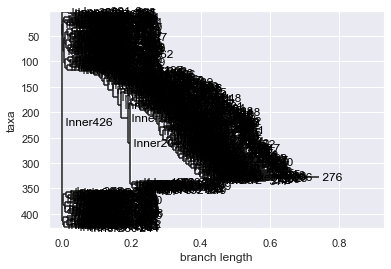

In [523]:
Phylo.draw(upgma_tree_covid)

In [524]:
Phylo.draw_ascii(upgma_tree_covid)

      _____________ 9
   __|
  |  |_____________ 311
  |
 ,|  ______________ 108
 ||,|
 ||||_____________ 23
 |||
 |||   ____________ 175
 | | ,|
 | | || __________ 239
 | | |||
 | |_| |___________ 116
 |   |
 |   |  ___________ 20
 |   |_|
 |     |___________ 344
 |
 |      ____________ 14
 |    _|
 |  _| |___________ 57
 | | |
 |_| |_____________ 13
 | |
 | | _______________ 124
 | ||
 |  |  ____________ 343
 |  |_|
 |    |____________ 224
 |
 |     ____________ 298
 |  __|
 | |  |____________ 313
 |_|
 | |    ___________ 250
 | |  _|
 | |_| |____________ 191
 |   |
 |   |_____________ 317
 |
 |      ___________ 195
 |  ___|
 | |   |____________ 284
 |,|
 ||| ______________ 419
 ||||
 || |_______________ 355
 ||
 ||     __________ 329
 ||  __|
 || |  | __________ 332
 || |  ||
 ||_|   |__________ 159
 |  |
 |  | _____________ 179
 |  ||
 |   |  _________ 214
 |   |_|
 |     |___________ 148
 |
 |      ____________ 218
 |    ,|
 |   _||____________ 51
 |  | |
 | ,| |______________ 259

### Drawing phylogenetic tree for a set of random sequences

In [525]:
import random
from Bio.SeqRecord import SeqRecord

mut = 0.1
BASES = {'A', 'T', 'G', 'C'}
seqs = []
seed = ''.join([random.choice(list(BASES)) for _ in range(25 + random.choice([-1, 0, 1]))])

seq_records = []

for i in range(20):
    new_seq = ''.join([b if random.random() > mut else random.choice(list(BASES - {b})) for b in seed])
    seq_records.append(SeqRecord(Seq(new_seq), id=str(i)))
    
# for sqr in seq_records:
#     print(sqr)

In [526]:
with open('data/seq_records.fasta', 'w') as f:
    SeqIO.write(seq_records, f, 'fasta')

In [527]:
with open('data/msa-1.clw', 'r') as aln:
    alignment = AlignIO.read(aln, 'clustal')

In [528]:
calculator = DistanceCalculator('identity')
dm = calculator.get_distance(alignment)

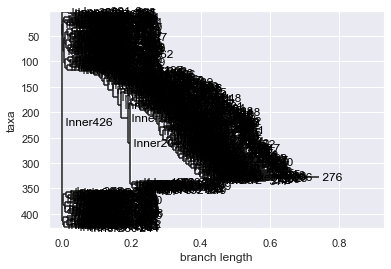

In [529]:
Phylo.draw(upgma_tree)

In [530]:
Phylo.draw_ascii(upgma_tree)

      _____________ 9
   __|
  |  |_____________ 311
  |
 ,|  ______________ 108
 ||,|
 ||||_____________ 23
 |||
 |||   ____________ 175
 | | ,|
 | | || __________ 239
 | | |||
 | |_| |___________ 116
 |   |
 |   |  ___________ 20
 |   |_|
 |     |___________ 344
 |
 |      ____________ 14
 |    _|
 |  _| |___________ 57
 | | |
 |_| |_____________ 13
 | |
 | | _______________ 124
 | ||
 |  |  ____________ 343
 |  |_|
 |    |____________ 224
 |
 |     ____________ 298
 |  __|
 | |  |____________ 313
 |_|
 | |    ___________ 250
 | |  _|
 | |_| |____________ 191
 |   |
 |   |_____________ 317
 |
 |      ___________ 195
 |  ___|
 | |   |____________ 284
 |,|
 ||| ______________ 419
 ||||
 || |_______________ 355
 ||
 ||     __________ 329
 ||  __|
 || |  | __________ 332
 || |  ||
 ||_|   |__________ 159
 |  |
 |  | _____________ 179
 |  ||
 |   |  _________ 214
 |   |_|
 |     |___________ 148
 |
 |      ____________ 218
 |    ,|
 |   _||____________ 51
 |  | |
 | ,| |______________ 259

# Virus Nucleotides Similarity with K-means & PCA

In [531]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [532]:
data = pd.read_csv('data/MN997409.1-4NY0T82X016-Alignment-HitTable.csv')

In [533]:
data.head()

,MN997409.1,MN997409.1.1,100.000,29882,0,0.1,1,29882.1,1.1,29882.2,0.0,55182
0,MN997409.1,MT020881.1,99.990,29882,3,0,1,29882,1,29882,0.0,55166
1,MN997409.1,MT020880.1,99.990,29882,3,0,1,29882,1,29882,0.0,55166
2,MN997409.1,MN985325.1,99.990,29882,3,0,1,29882,1,29882,0.0,55166
3,MN997409.1,MN975262.1,99.990,29882,3,0,1,29882,1,29882,0.0,55166
4,MN997409.1,LC522974.1,99.993,29878,2,0,4,29881,1,29878,0.0,55164


In [534]:
data = data.rename(columns={"MN997409.1": "query acc.ver", "MN997409.1.1": "subject acc.ver",
                            "100.000":"% identity","29882":"alignment length","0":"mismatches",
                            "0.1":"gap opens","1":"q. start","29882.1":"q. end","1.1":"s. start",
                           "29882.2	":"s. end","0.0":"evalue","55182":"bit score"})

In [535]:
data.head()

,query acc.ver,subject acc.ver,% identity,alignment length,mismatches,gap opens,q. start,q. end,s. start,29882.2,evalue,bit score
0,MN997409.1,MT020881.1,99.990,29882,3,0,1,29882,1,29882,0.0,55166
1,MN997409.1,MT020880.1,99.990,29882,3,0,1,29882,1,29882,0.0,55166
2,MN997409.1,MN985325.1,99.990,29882,3,0,1,29882,1,29882,0.0,55166
3,MN997409.1,MN975262.1,99.990,29882,3,0,1,29882,1,29882,0.0,55166
4,MN997409.1,LC522974.1,99.993,29878,2,0,4,29881,1,29878,0.0,55164


In [536]:
data = data.append(pd.Series(['MN997409.1',	'MN997409.1.1',	
                    100.000,	29882,	
                    0,	0.1,	1,	29882.1,	
                    1.1,	29882.2,	0.0,	55182], index=data.columns), ignore_index=True)

In [537]:
data.tail()

,query acc.ver,subject acc.ver,% identity,alignment length,mismatches,gap opens,q. start,q. end,s. start,29882.2,evalue,bit score
258,MN997409.1,AY282752.2,82.304,17716,2948,169.0,3956,21577.0,3868.0,21490.0,0.0,15175
259,MN997409.1,AY282752.2,80.063,5417,988,68.0,22539,27910.0,22414.0,27783.0,0.0,3936
260,MN997409.1,AY282752.2,90.189,1641,142,12.0,28257,29882.0,28088.0,29724.0,0.0,2121
261,MN997409.1,AY282752.2,79.305,1928,358,35.0,16,1923.0,1.0,1907.0,0.0,1312
262,MN997409.1,MN997409.1.1,100.000,29882,0,0.1,1,29882.1,1.1,29882.2,0.0,55182


In [538]:
data.shape

(263, 12)

In [539]:
data.describe()

,% identity,alignment length,mismatches,gap opens,q. start,q. end,s. start,29882.2,evalue,bit score
count,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.0,263.00000
mean,86.064958,10711.114068,919.235741,57.821673,11295.684411,21970.517490,11212.646768,21888.837262,0.0,14240.34981
std,7.609654,10530.955700,1085.784789,60.654416,12022.056513,10652.171126,11963.759134,10619.704332,0.0,19226.72192
min,77.559000,1603.000000,0.000000,0.000000,1.000000,1923.000000,1.000000,1672.000000,0.0,1011.00000
25%,80.048000,1925.000000,142.000000,12.000000,16.000000,21577.000000,1.050000,21489.000000,0.0,2101.00000
50%,82.304000,5417.000000,359.000000,35.000000,3956.000000,27910.000000,3875.000000,27783.000000,0.0,3936.00000
75%,90.189000,17716.000000,989.000000,68.000000,22539.000000,29875.500000,22429.000000,29729.000000,0.0,15175.00000
max,100.000000,29882.000000,2952.000000,172.000000,28257.000000,29882.100000,28137.000000,30256.000000,0.0,55182.00000


In [540]:
data.corr()

,% identity,alignment length,mismatches,gap opens,q. start,q. end,s. start,29882.2,evalue,bit score
% identity,1.000000,0.631524,-0.453509,-0.535174,-0.052519,0.566794,-0.051870,0.569653,NaN,0.793438
alignment length,0.631524,1.000000,0.206680,0.136714,-0.560720,0.355570,-0.560761,0.359521,NaN,0.944639
mismatches,-0.453509,0.206680,1.000000,0.988180,-0.197306,-0.021370,-0.198956,-0.022302,NaN,-0.125766
gap opens,-0.535174,0.136714,0.988180,1.000000,-0.183218,-0.074691,-0.184789,-0.075778,NaN,-0.193213
q. start,-0.052519,-0.560720,-0.197306,-0.183218,1.000000,0.574516,0.999987,0.571028,NaN,-0.502689
q. end,0.566794,0.355570,-0.021370,-0.074691,0.574516,1.000000,0.574465,0.999974,NaN,0.367344
s. start,-0.051870,-0.560761,-0.198956,-0.184789,0.999987,0.574465,1.000000,0.571007,NaN,-0.502181
29882.2,0.569653,0.359521,-0.022302,-0.075778,0.571028,0.999974,0.571007,1.000000,NaN,0.371660
evalue,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
bit score,0.793438,0.944639,-0.125766,-0.193213,-0.502689,0.367344,-0.502181,0.371660,NaN,1.000000


Text(0.5, 1.0, 'Correlation between different fearures')

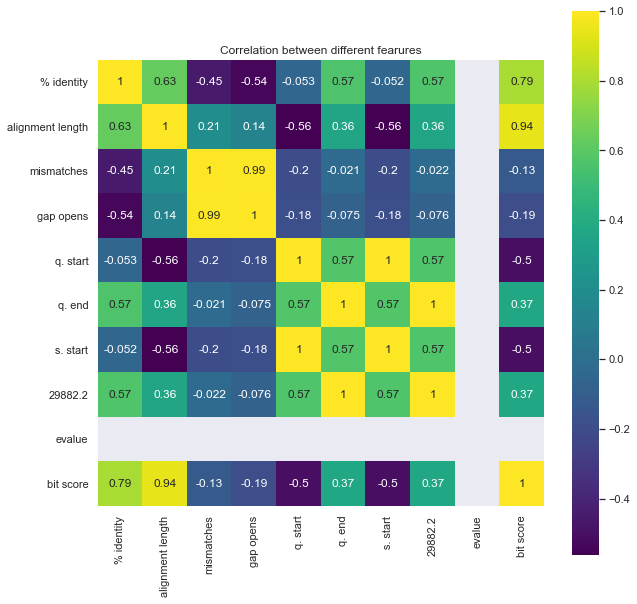

In [541]:
plt.figure(figsize=(10,10))
sns.heatmap(data.corr(), vmax=1, square=True,annot=True,cmap='viridis')

plt.title('Correlation between different fearures')

### k-Means Clustering

In [542]:
from sklearn.cluster import KMeans

In [543]:
data['subject acc.ver'] = data['subject acc.ver'].astype("category").cat.codes

In [544]:
data.head()

,query acc.ver,subject acc.ver,% identity,alignment length,mismatches,gap opens,q. start,q. end,s. start,29882.2,evalue,bit score
0,MN997409.1,86,99.990,29882,3,0.0,1,29882.0,1.0,29882.0,0.0,55166
1,MN997409.1,85,99.990,29882,3,0.0,1,29882.0,1.0,29882.0,0.0,55166
2,MN997409.1,66,99.990,29882,3,0.0,1,29882.0,1.0,29882.0,0.0,55166
3,MN997409.1,65,99.990,29882,3,0.0,1,29882.0,1.0,29882.0,0.0,55166
4,MN997409.1,55,99.993,29878,2,0.0,4,29881.0,1.0,29878.0,0.0,55164


In [545]:
X = data.iloc[:,1:].values

### Using Silhouette Score for Evaluating Clusters

In [546]:
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm

In [547]:
from sklearn.preprocessing import StandardScaler
standardized_data = StandardScaler().fit_transform(X)
print(standardized_data.shape)

(263, 11)


For n_clusters = 2 The average silhouette_score is : 0.6051456304424346
For n_clusters = 3 The average silhouette_score is : 0.7737574709178652
For n_clusters = 4 The average silhouette_score is : 0.9304299438199628
For n_clusters = 5 The average silhouette_score is : 0.9626586534510194
For n_clusters = 6 The average silhouette_score is : 0.9625756535242549
For n_clusters = 7 The average silhouette_score is : 0.9585239650538647
For n_clusters = 8 The average silhouette_score is : 0.9614207899227608
For n_clusters = 9 The average silhouette_score is : 0.9626169262248866
For n_clusters = 10 The average silhouette_score is : 0.9644636830559539


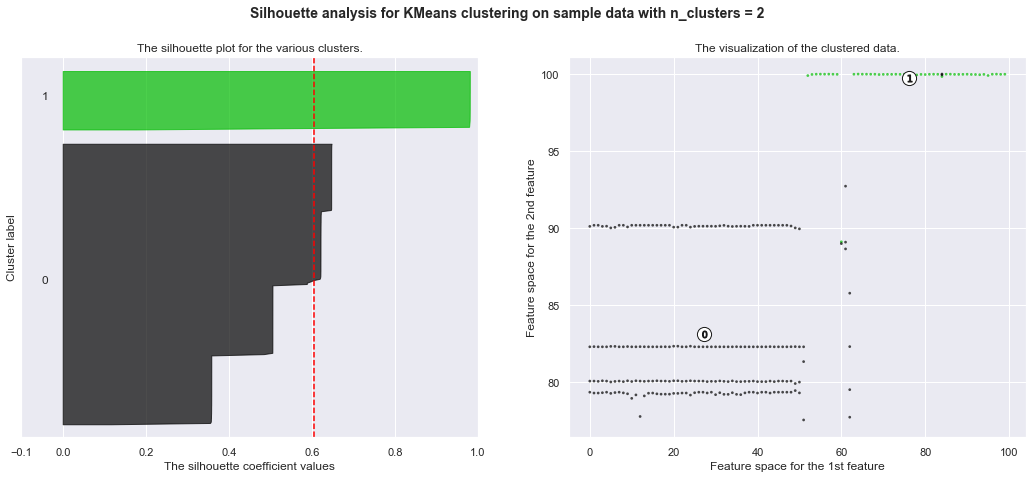

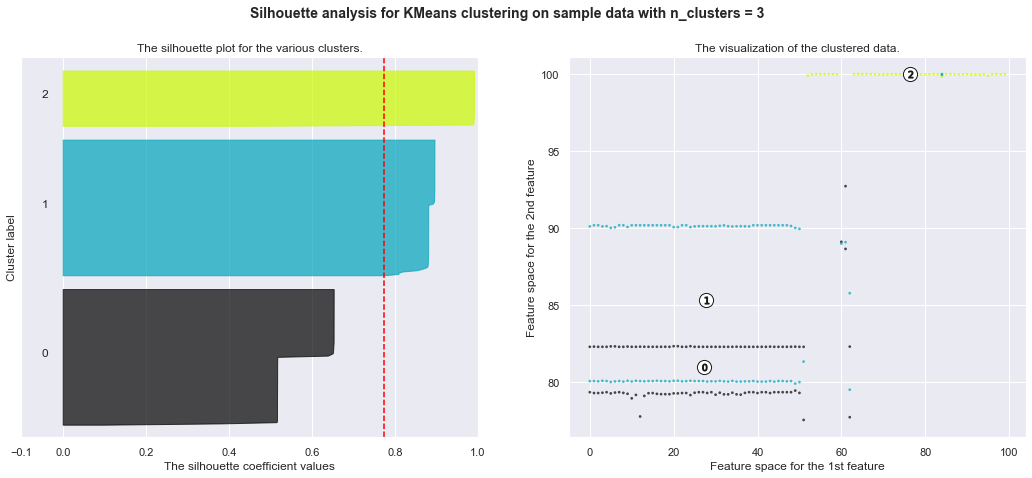

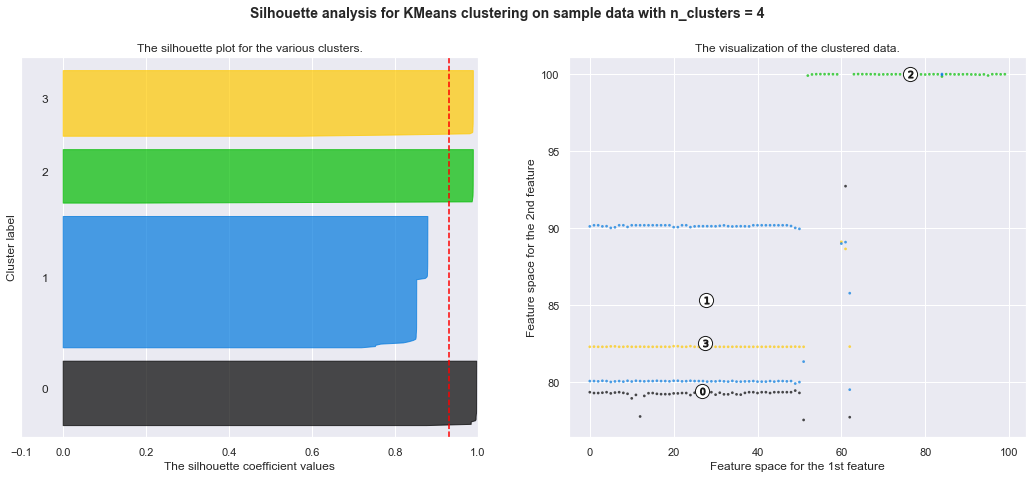

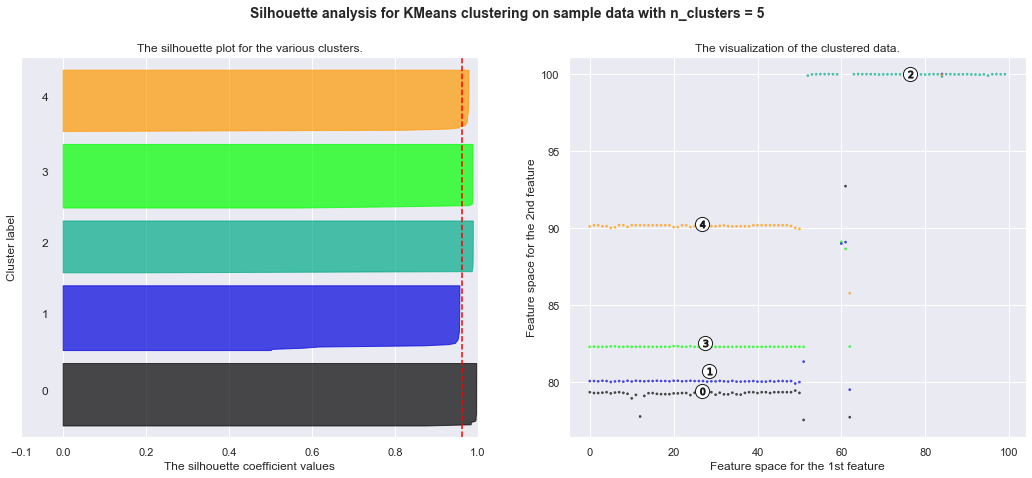

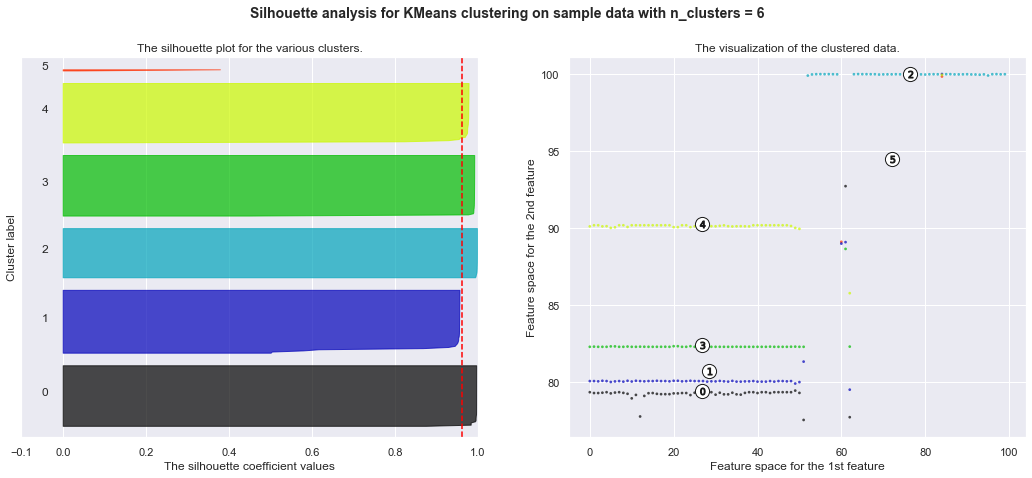

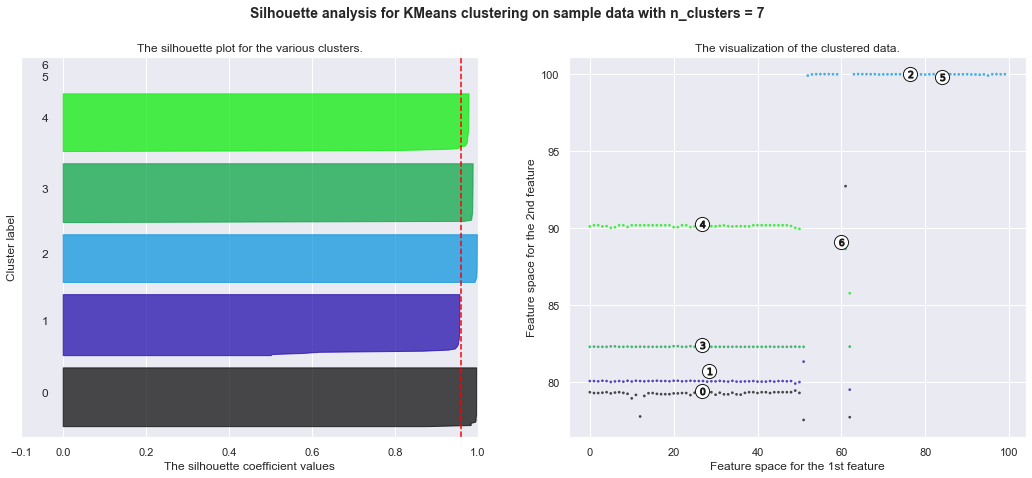

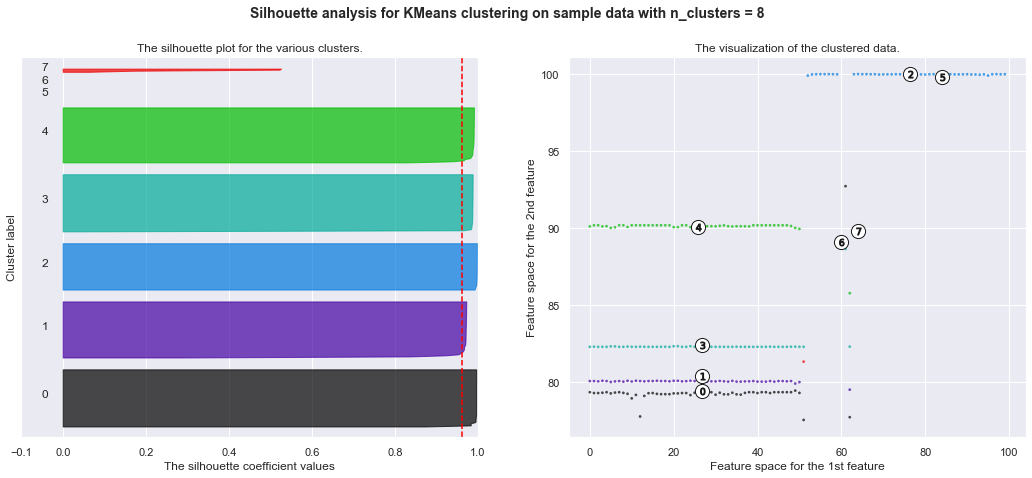

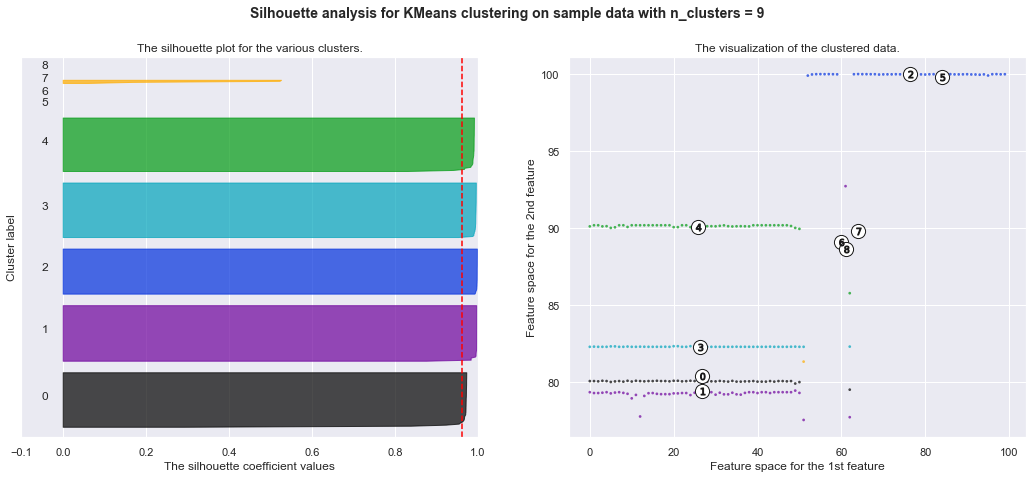

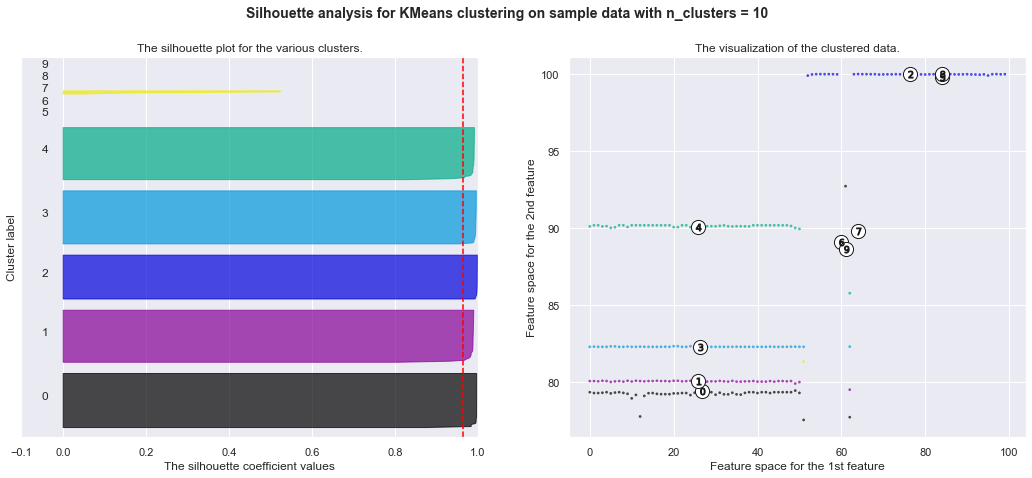

In [548]:
range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

### PCA Visualization

In [549]:
covar_matrix = np.matmul(standardized_data.T , standardized_data)

In [550]:
covar_matrix.shape

(11, 11)

In [551]:
from scipy.linalg import eigh 

In [552]:
#top2 eigenvalue
values, vectors = eigh(covar_matrix, eigvals=(9,10))

In [553]:
vectors.shape

(11, 2)

In [554]:
#transpose
vectors = vectors.T
vectors.shape

(2, 11)

In [555]:
new_coordinates = np.matmul(vectors, standardized_data.T)
print ("Resultant at new data shape: ", vectors.shape, "*", standardized_data.T.shape," = ", new_coordinates.shape)

Resultant at new data shape:  (2, 11) * (11, 263)  =  (2, 263)


In [556]:
new_coordinates = np.vstack((new_coordinates)).T

df = pd.DataFrame(data=new_coordinates, columns=("1st_principal", "2nd_principal"))
print(df.head())

   1st_principal  2nd_principal
0      -0.811932      -4.340659
1      -0.808541      -4.324404
2      -0.744119      -4.015558
3      -0.740728      -3.999302
4      -0.706546      -3.836705


C:\Users\Thilina\.conda\envs\MScDM2020\lib\site-packages\seaborn\axisgrid.py:316: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


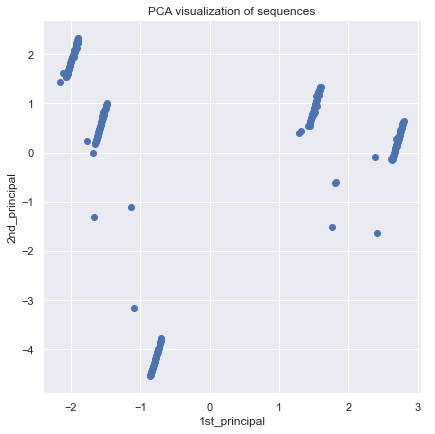

In [557]:
sns.set()
sns.FacetGrid(df, size=6).map(plt.scatter, '1st_principal', '2nd_principal').add_legend()
plt.title('PCA visualization of sequences')
plt.show()